In [1]:
#import
import pandas as pd
import numpy as np
import os
from datetime import datetime

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import warnings
import itertools

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, minmax_scale

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [2]:
#define
SESSION_PATH = './sessions'
WELLNESS_PATH = './wellness'
PICKLE_PATH = './pickle/'
format = '%Y-%m-%d'
lista_colonne_utili_analisi_esercizi = ['splitName',
#                                         'playerName',
                                        'workload',
                                        'perceivedWorkload',
                                        'metabolicWorkload',
                                        'mechanicalWorkload',
                                        'kinematicWorkload',
                                        'cardioWorkload']

#colonne da shiftare verso l'alto

lista_colonne_workload = [
    'workload-1',
    'workload-2',
    'workload-3',
    'workload-4',
    'workload-5'
                        ]
lista_colonne_rpe = [
    'rpe-1',
    'rpe-2',
    'rpe-3',
    'rpe-4',
    'rpe-5'
]
lista_colonne_Go_score = [
    'Go_score-1',
    'Go_score-2',
    'Go_score-3',
    'Go_score-4',
    'Go_score-5'
]

######################################
lista_category = [[lista_colonne_workload,'workload'],[lista_colonne_rpe,'rpe'],[lista_colonne_Go_score,'Go_score']]
######################################
#colonne per DNN


#pesi per calcolare GO_Score

SLEEP_PAR = [0.1, 0.1, 0.5, 0.8, 1]
STRESS_PAR = [0.1, 0.1, 1, 1, 1]
FATIGUE_PAR = [0.1, 0.1, 0.5, 0.8, 1]
SORENESS_PAR = [0.1, 0.1, 0.5, 0.8, 1]
MOOD_PAR = [0.1, 0.1, 1, 1, 1]

#script per calcolare nomi colonne
nome = 'Go_score'
n = 5
lista = []
for i in range(-n,0):
    lista.append(nome+str(i))
reversed(lista)

In [3]:
def from_str_to_date(stringa):
    timestr = stringa.split(' ')[0]
    time = datetime.strptime(timestr, format)
    return time

def calcola_go(df):
    df['Go_score'] = SLEEP_PAR[int(df['wellness_sleep']) - 1] + STRESS_PAR[int(df['wellness_stress']) - 1] + FATIGUE_PAR[int(df['wellness_fatigue']) - 1] + SORENESS_PAR[int(df['wellness_soreness']) - 1] + MOOD_PAR[int(df['wellness_mood']) - 1]
    return df

CREO UN DB CON I DATI DI TUTTI I GIOCATORI, CON COLONNE RIFERITE AI GIORNI PRECEDENTI
===========================

In [4]:
# importo csv associati a ogni player
list_files1 = os.listdir(PICKLE_PATH)
list_file = list_files1.copy()

# tolgo dalla lista dei files quelli non di player
for file in list_files1:
    if 'Player' not in file:
        list_file.remove(file)
    elif 'csv' in file:
        list_file.remove(file)

df_total = pd.DataFrame()
#per ogni file, creo e preparo il db da dare al DNN
for file in list_file:
    print(file)
    player = file.split('.')[0]
    globals()[player] = pd.read_pickle(PICKLE_PATH + file)
    
    #calcolo go score
    df_player = globals()[player].apply(calcola_go, axis=1)

    #drop delle colonne inutili
    df_player = df_player.drop(['exercises','playerName','wellness_fatigue','wellness_mood','complete',
                                'wellness_sleep','wellness_soreness','wellness_stress','Work Ratio','rpeTl','duration'], axis=1)
    
    ######################################################################################################
    for category in lista_category:
        i = 1
        for column in category[0]:
            df_player[column] = df_player[category[1]].shift(i)
            i += 1

    
    df_player = df_player.dropna(how='any')
    
    globals()[player] = df_player.copy()
    df_total = df_total.append(df_player, ignore_index=True)

#rinomino la colonna Player Load
df_total.rename(columns={'Player Load': 'Player_Load'}, inplace=True)

Player1.pickle
Player10.pickle
Player11.pickle
Player12.pickle
Player13.pickle
Player14.pickle
Player15.pickle
Player16.pickle
Player17.pickle
Player18.pickle
Player19.pickle
Player2.pickle
Player20.pickle
Player21.pickle
Player23.pickle
Player24.pickle
Player25.pickle
Player26.pickle
Player27.pickle
Player28.pickle
Player29.pickle
Player3.pickle
Player30.pickle
Player31.pickle
Player32.pickle
Player4.pickle
Player5.pickle
Player6.pickle
Player7.pickle
Player9.pickle


file = list_file[0]
player = file.split('.')[0]
globals()[player] = pd.read_pickle(PICKLE_PATH + file)

#calcolo go score
df_player = globals()[player].apply(calcola_go, axis=1)

#drop delle colonne inutili
df_player = df_player.drop(['exercises','playerName','wellness_fatigue','wellness_mood','complete',
                            'wellness_sleep','wellness_soreness','wellness_stress','Work Ratio','rpeTl','duration'], axis=1)
df_player

#creo colonne per i workload
i = 1
for column in lista_colonne_workload:
    df_player[column] = df_player['workload'].shift(i)
    i += 1

#creo colonne per i rpe
i = 1
for column in lista_colonne_rpe:
    df_player[column] = df_player['rpe'].shift(i)
    i += 1

#creo colonne per i Go_score
i = 1
for column in lista_colonne_Go_score:
    df_player[column] = df_player['Go_score'].shift(i)
    i += 1

df_player.dropna(how='any')

In [5]:
df_total

,date,rpe,workload,perceivedWorkload,metabolicWorkload,mechanicalWorkload,kinematicWorkload,cardioWorkload,intensity,Player_Load,...,rpe-1,rpe-2,rpe-3,rpe-4,rpe-5,Go_score-1,Go_score-2,Go_score-3,Go_score-4,Go_score-5
0,2017-08-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,3.0,0.0,0.0,3.0,3.0,3.8,3.1,4.4,4.4,4.1
1,2017-08-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,3.0,0.0,0.0,3.0,4.4,3.8,3.1,4.4,4.4
2,2017-08-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,3.0,0.0,0.0,2.2,4.4,3.8,3.1,4.4
3,2017-08-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,3.0,0.0,3.8,2.2,4.4,3.8,3.1
4,2017-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,3.0,3.8,3.8,2.2,4.4,3.8
5,2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,3.8,3.8,3.8,2.2,4.4
6,2017-08-12,1.0,0.4,10.0,1.3,6.8,0.0,0.0,27.7,193.5171,...,0.0,0.0,0.0,0.0,0.0,4.4,3.8,3.8,3.8,2.2
7,2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,1.0,0.0,0.0,0.0,0.0,3.8,4.4,3.8,3.8,3.8
8,2017-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,1.0,0.0,0.0,0.0,3.8,3.8,4.4,3.8,3.8
9,2017-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,1.0,0.0,0.0,3.8,3.8,3.8,4.4,3.8


In [6]:
df_total.columns.values

array(['date', 'rpe', 'workload', 'perceivedWorkload',
       'metabolicWorkload', 'mechanicalWorkload', 'kinematicWorkload',
       'cardioWorkload', 'intensity', 'Player_Load', 'Go_score',
       'workload-1', 'workload-2', 'workload-3', 'workload-4',
       'workload-5', 'rpe-1', 'rpe-2', 'rpe-3', 'rpe-4', 'rpe-5',
       'Go_score-1', 'Go_score-2', 'Go_score-3', 'Go_score-4',
       'Go_score-5'], dtype=object)

In [7]:
df_total['Go_score'].value_counts()

4.4    3631
5.0     832
4.1     663
4.8     592
4.6     440
3.8     262
4.3     113
4.5      88
3.5      43
4.0      41
3.1      17
3.4      15
3.6      14
2.7      12
3.9       8
3.4       7
3.7       6
3.0       5
3.9       5
2.3       2
2.6       2
3.2       2
1.8       2
2.1       1
1.8       1
0.9       1
0.9       1
2.3       1
0.5       1
3.7       1
2.2       1
Name: Go_score, dtype: int64

RETE NEURALE 
============================

In [8]:
#define
OUTPUT = 'Go_score'
EPOCHS = 500
HIDDEN_UNITS = [20,10]

In [9]:
#drop colonne inutili
train = df_total.drop(['date','cardioWorkload','intensity','Player_Load'],axis = 1)

#drop dati a 0
train = train[train['workload']!=0]

#droppo colonne con parametri go troppo bassi
colonne_go = ['Go_score','Go_score-1', 'Go_score-2', 'Go_score-3', 'Go_score-4',
       'Go_score-5']
for colonna in colonne_go:
    train = train[train[colonna]>= 4]

#muovo go_score in fondo
serie = train[OUTPUT]
train = train.drop([OUTPUT],axis=1)
train[OUTPUT] = serie

input_dataset = train.copy()
train

,rpe,workload,perceivedWorkload,metabolicWorkload,mechanicalWorkload,kinematicWorkload,workload-1,workload-2,workload-3,workload-4,...,rpe-2,rpe-3,rpe-4,rpe-5,Go_score-1,Go_score-2,Go_score-3,Go_score-4,Go_score-5,Go_score
17,4.0,2.3,46.0,38.5,58.8,37.9,1.8,0.0,1.1,1.1,...,0.0,3.0,3.0,5.0,4.1,4.4,4.4,4.4,4.4,4.4
71,3.0,2.1,32.1,29.9,29.5,65.6,0.0,0.0,1.7,1.3,...,0.0,3.0,3.0,5.0,4.0,4.4,4.4,4.4,4.4,4.3
72,5.0,3.3,65.9,69.0,48.4,77.1,2.1,0.0,0.0,1.7,...,0.0,0.0,3.0,3.0,4.3,4.0,4.4,4.4,4.4,4.8
159,2.0,0.6,21.7,0.0,3.3,0.0,0.0,5.5,1.9,3.3,...,11.0,3.5,5.0,3.5,4.3,4.4,4.5,4.8,4.4,4.4
160,3.5,1.4,33.8,23.9,29.0,27.1,0.6,0.0,5.5,1.9,...,0.0,11.0,3.5,5.0,4.4,4.3,4.4,4.5,4.8,4.6
161,0.0,2.3,0.0,44.8,41.9,50.6,1.4,0.6,0.0,5.5,...,2.0,0.0,11.0,3.5,4.6,4.4,4.3,4.4,4.5,4.5
163,0.0,2.4,0.0,33.9,66.6,38.3,0.0,2.3,1.4,0.6,...,0.0,3.5,2.0,0.0,4.1,4.5,4.6,4.4,4.3,4.5
164,10.5,3.8,107.3,55.5,71.9,0.0,2.4,0.0,2.3,1.4,...,0.0,0.0,3.5,2.0,4.5,4.1,4.5,4.6,4.4,4.4
237,8.0,3.4,84.6,62.8,44.2,63.0,0.0,0.0,0.0,1.2,...,0.0,0.0,3.0,3.0,4.4,4.4,5.0,5.0,4.8,4.8
238,5.0,2.2,58.8,40.4,33.2,39.0,3.4,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,4.8,4.4,4.4,5.0,5.0,4.4


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\LucaC\\AppData\\Local\\Temp\\tmp7en4g8uk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002593BFCD860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\LucaC\AppData\Local\Temp\tmp7en4g8uk

c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


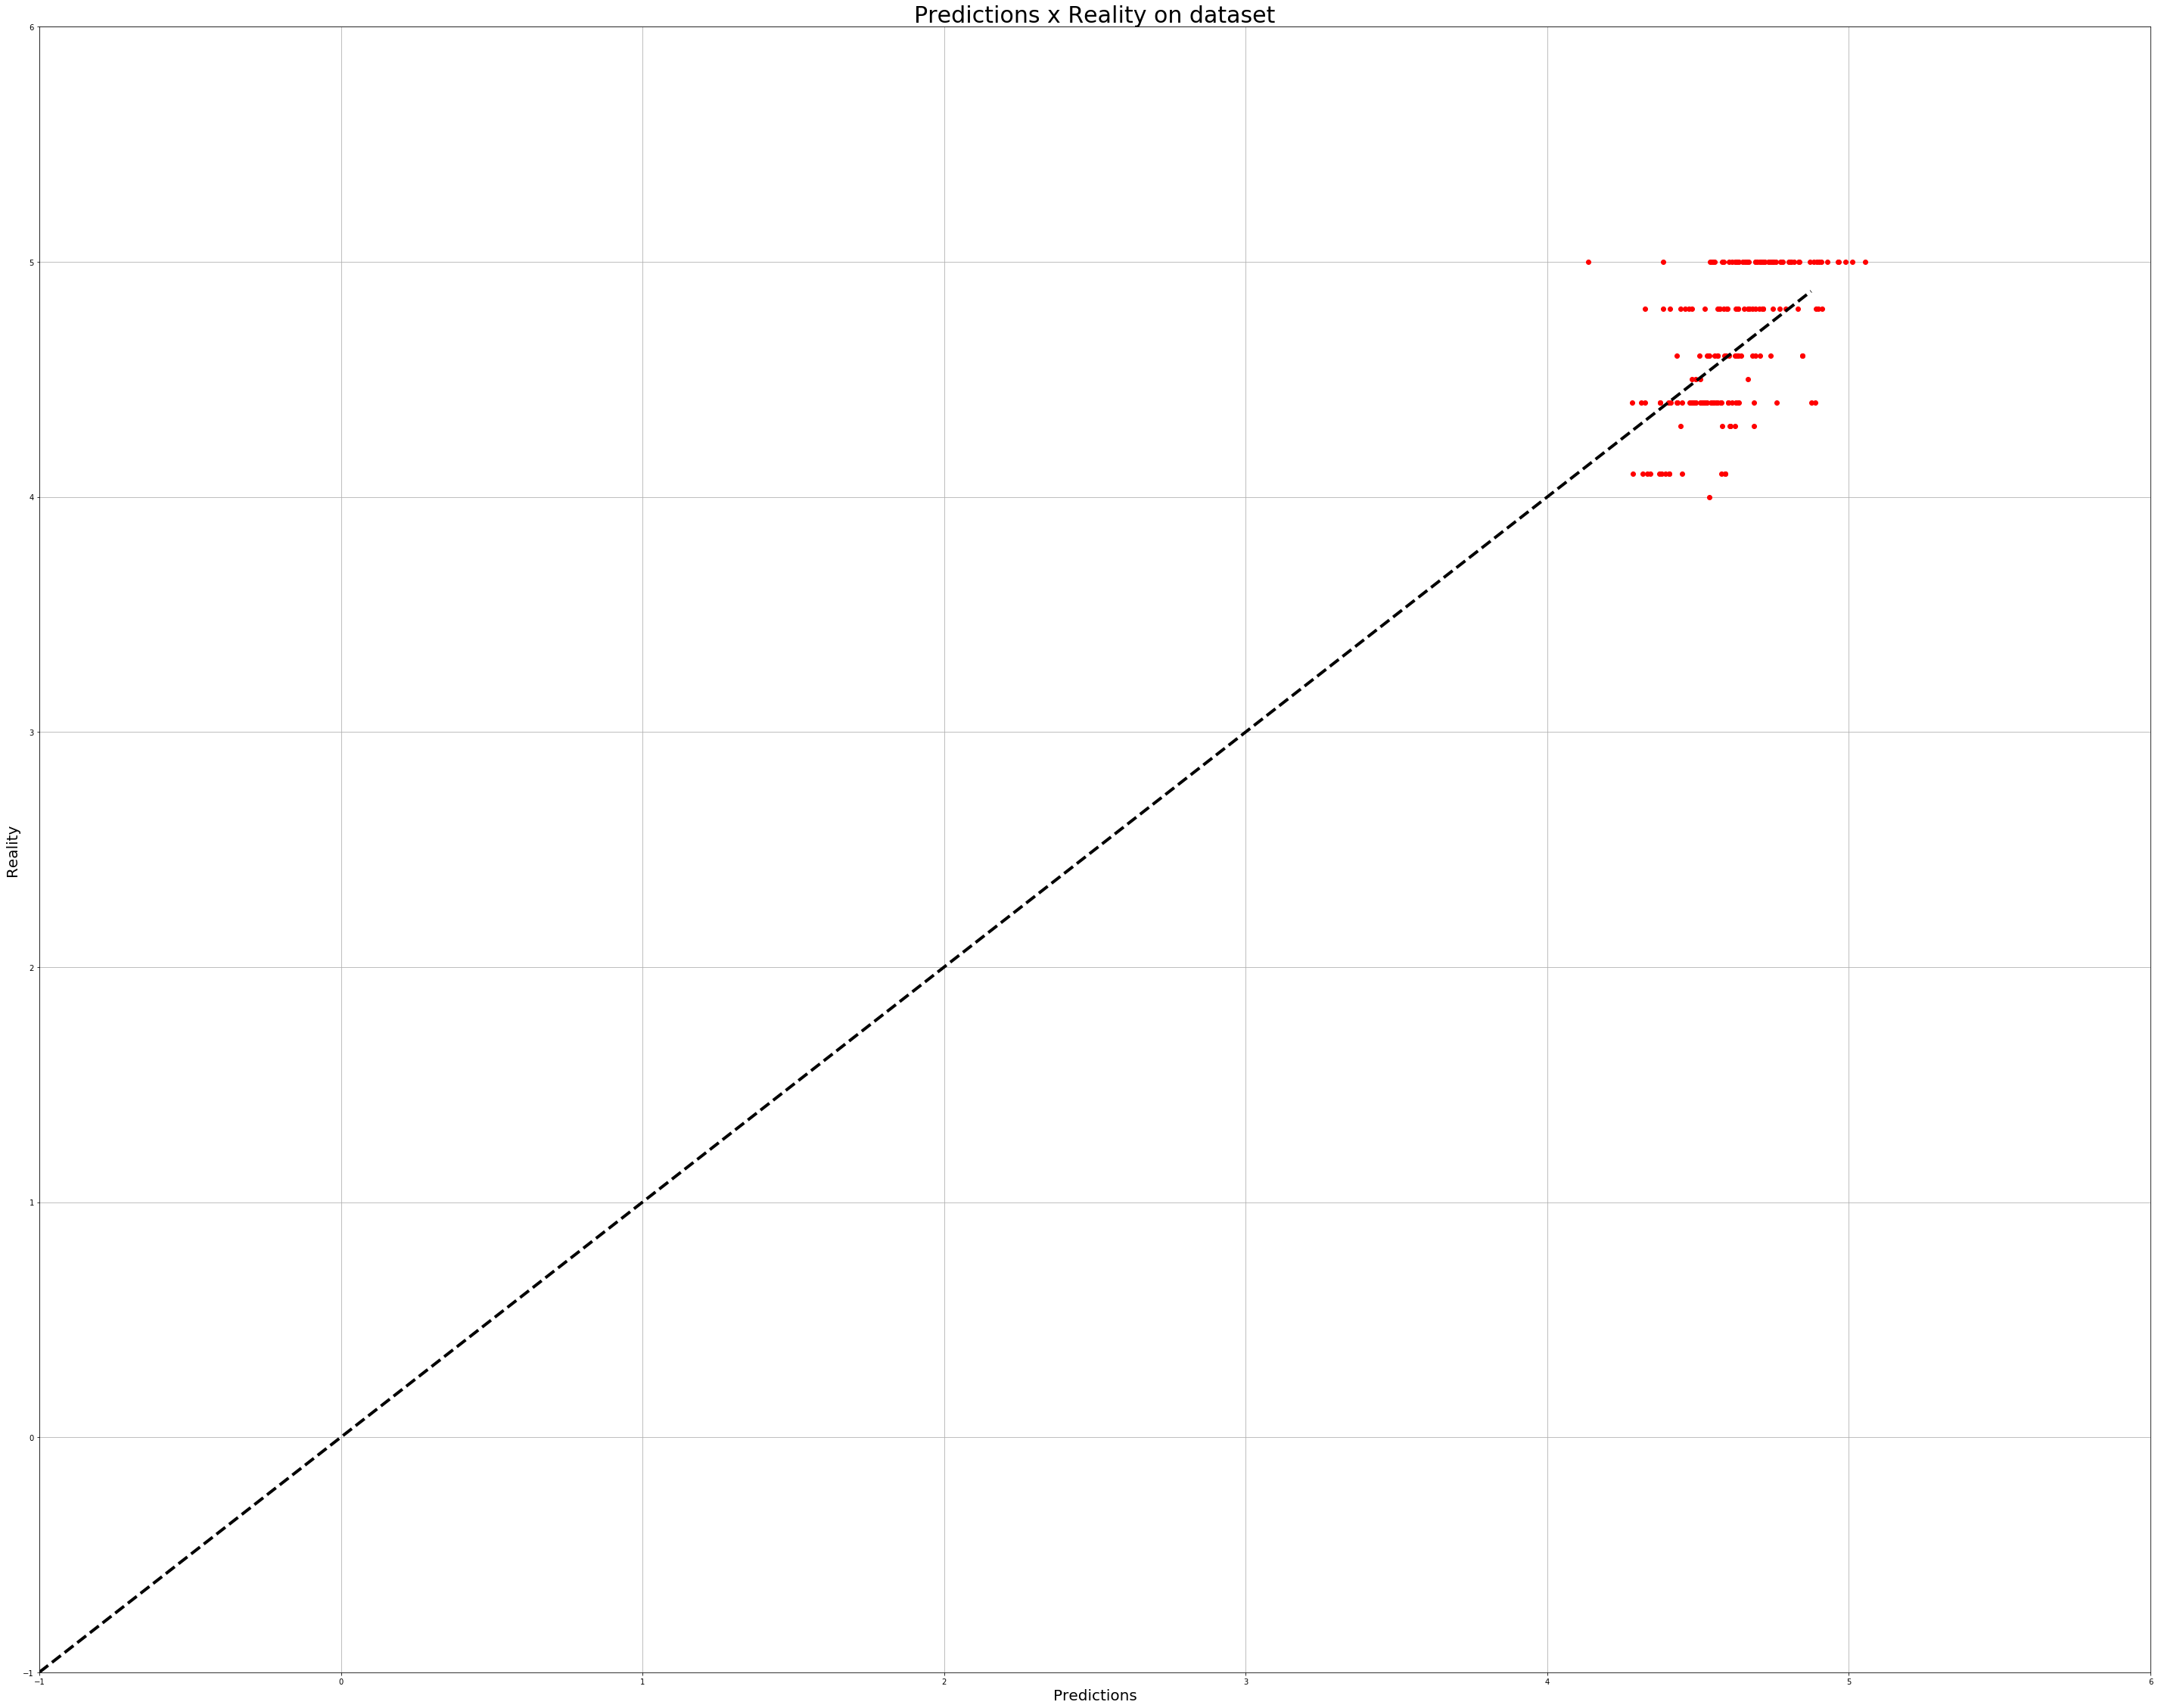

In [10]:
# Isolate outliers with an IsolationForest algorithm


'''clf = IsolationForest(max_samples=30, random_state=42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns=['Top'])
y_noano[y_noano['Top'] == 1].index.values
train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop=True, inplace=True)
print('')
print('Number of Outliers:', y_noano[y_noano['Top'] == -1].shape[0])
print('Number of rows without outliers:', train.shape[0])
'''

# Preprocessing dataset with MinMaxScale function

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove(OUTPUT)

# mat_train = np.matrix(train)
# #mat_input = np.matrix(input_dataset)
# mat_new = np.matrix(train.drop(OUTPUT, axis=1))
# mat_y = np.array(train[OUTPUT].reshape((train.shape[0], 1)))

# prepro_y = MinMaxScaler()
# prepro_y.fit(mat_y)

# prepro = MinMaxScaler()
# prepro.fit(mat_train)

# prepro_input = MinMaxScaler()
# prepro_input.fit(mat_new)

mat_train = train.copy()
prepro = MinMaxScaler(copy=True, feature_range=(0, 1))

prepro_y = MinMaxScaler()
mat_y = prepro_y.fit_transform(train[OUTPUT].values.reshape(-1,1))

train = pd.DataFrame(prepro.fit_transform(mat_train), columns=col_train)

#input_dataset = pd.DataFrame(prepro_input.transform(mat_input), columns=col_train_bis)

# TensorFlow deep neural network

# List of features

COLUMNS = col_train
FEATURES = col_train_bis

# Columns for tensorflow

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict

training_set = train[COLUMNS]
prediction_set = train[OUTPUT]

# Train and Test split


x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES], prediction_set, test_size=0.1, random_state=42)
y_train = pd.DataFrame(y_train, columns=[OUTPUT])
training_set = pd.DataFrame(x_train, columns=FEATURES).merge(y_train, left_index=True, right_index=True)


# Training for submission


training_sub = training_set[col_train]
y_test = pd.DataFrame(y_test, columns=[OUTPUT])
testing_set = pd.DataFrame(x_test, columns=FEATURES).merge(y_test, left_index=True, right_index=True)


# Model

tf.logging.set_verbosity(tf.logging.INFO)
regressor = tf.estimator.DNNRegressor(hidden_units= HIDDEN_UNITS, feature_columns=feature_cols, activation_fn=tf.nn.relu) # model_dir = 'regressor'

# Reset the index of training

training_set.reset_index(drop=True, inplace=True)

# Deep Neural Network Regressor with the training set which contain the data split by train test split

regressor.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = training_set, y = training_set[OUTPUT], 
                                                             shuffle=False), steps=EPOCHS)

# Evaluation on the test set created by train_test_split


ev = regressor.evaluate(input_fn=tf.estimator.inputs.pandas_input_fn(x = testing_set,y = testing_set[OUTPUT],
                                                                     shuffle=False), steps=1)


# Display the score on the testing set


loss_score1 = ev['loss']
print('')
print('Final Loss on the testing set: {0:f}'.format(loss_score1))
print('')

# Predictions on testing set


y = regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(testing_set, shuffle=False))
predictions = list(itertools.islice(y, testing_set.shape[0]))


# Plot predictions x reality on dataset graph


predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in predictions]).reshape(len(x_test), 1))
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([-1, 6])
axes.set_ylim([-1, 6])
plt.style.use('default')
plt.plot(predictions, reality, 'ro', color='red')
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Reality', fontsize=20)
plt.title('Predictions x Reality on dataset', fontsize=30)
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()